In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import json
import urllib.request

# Load ImageNet class labels from PyTorch's GitHub
url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
labels = []
with urllib.request.urlopen(url) as f:
    labels = [line.decode('utf-8').strip() for line in f.readlines()]

In [ ]:

# Imports
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Define transform (ImageNet-style)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = ImageFolder("/content/drive/MyDrive/ImageNetSamples", transform=transform)


Mounted at /content/drive


In [31]:
import random
# Pick random image from dataset
img_tensor, label = random.choice(dataset)

# Prepare input for model
input_img = img_tensor.unsqueeze(0)  # Add batch dimension


(-0.5, 223.5, 223.5, -0.5)

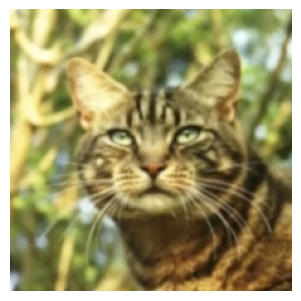

In [32]:
img_np = input_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
img_np = np.clip(img_np, 0, 1)
original_img = img_np
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
# plt.title("Original Image")
plt.axis('off')

In [33]:
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.eval()

In [34]:
import torch.nn.functional as F

# Run inference
output = model(input_img)
output = F.softmax(output, dim=1)

# Get top prediction
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx = pred_label_idx.item()
prediction_score = prediction_score.item()

# Use the labels list
predicted_label = labels[pred_label_idx]
print('Predicted:', predicted_label, '(', prediction_score, ')')


Predicted: tabby ( 0.7334997653961182 )


In [35]:
import cv2




# --- Grad-CAM setup (last conv layer) ---
target_layer = model.layer4[1].conv2
layer_gc = LayerGradCam(model, target_layer)

# Compute Grad-CAM
attribution = layer_gc.attribute(input_img, target=pred_label_idx)

# Upsample Grad-CAM to image size
upsampled_attr = torch.nn.functional.interpolate(
    attribution, size=(224, 224), mode='bilinear', align_corners=False
)

# Convert to numpy and normalize
heatmap = upsampled_attr.squeeze().cpu().detach().numpy()
heatmap = np.maximum(heatmap, 0)  # ReLU
heatmap = heatmap / heatmap.max()

# Convert image to displayable format
img = input_img.squeeze(0)
original_img = img.permute(1, 2, 0).numpy()
original_img = (original_img * np.array([0.229, 0.224, 0.225]) +
                np.array([0.485, 0.456, 0.406]))
original_img = np.clip(original_img, 0, 1)

# Resize heatmap and overlay
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
overlay = heatmap_color.astype(np.float32) / 255 + original_img
overlay = overlay / overlay.max()




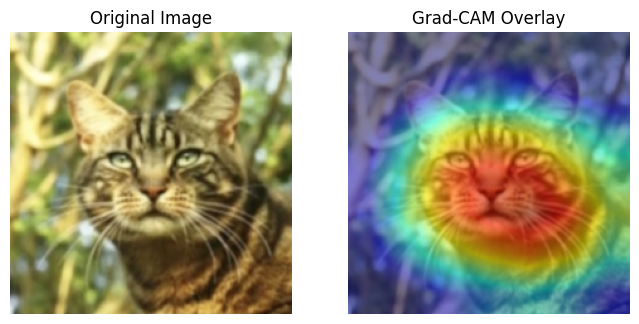

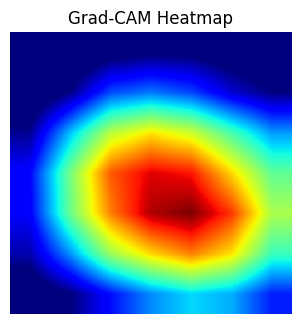

In [36]:
# --- Plot ---
# Use PIL directly to avoid issues with normalization artifacts
# Convert tensor to numpy image for overlay (unnormalize it first)
from captum.attr import LayerGradCam
import torch.nn.functional as F

img_np = input_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
img_np = np.clip(img_np, 0, 1)
original_img = img_np

overlay = heatmap_color.astype(np.float32) / 255 + original_img
overlay = overlay / overlay.max()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()

# Plot upsampled heatmap (no overlay)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
plt.imshow(heatmap,cmap='jet')  # Use the heatmap as is
plt.axis('off')
plt.title("Grad-CAM Heatmap")
plt.show()